In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Config

In [ ]:
# config
random_seed = 42
data_size = 100000
batch_size = 64
num_classes = 14
pos_weight = None # We plan to implement "pos_weight" in future experiment
num_epochs = 4
freeze_encoder_epochs = 2

# Dataset

In [ ]:
def split_data(label_file, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    labels_df = pd.read_csv(label_file)[:data_size]
    
    train_df, temp_df = train_test_split(labels_df, test_size=(1 - train_ratio), random_state=random_seed)
    val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)
    
    return train_df, val_df, test_df

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class CXRDataset(Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        
        img_name = row['ImageID']
        labels = row.iloc[:14].values.astype(int)
        
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels, dtype=torch.int64)

In [ ]:
label_file = "<file_location>/data_preprocessed.csv"
image_dir = "<file_location>"

train_df, val_df, test_df = split_data(label_file)

train_dataset = CXRDataset(image_dir=image_dir, labels_df=train_df, transform=transform)
val_dataset = CXRDataset(image_dir=image_dir, labels_df=val_df, transform=transform)
test_dataset = CXRDataset(image_dir=image_dir, labels_df=test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# U-Net

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(UNet, self).__init__()
        
        # U-Net Encoder: ResNet Backbone
        self.base_model = models.resnet34(pretrained=True)
        self.conv1 = self.base_model.conv1
        self.bn1 = self.base_model.bn1
        self.relu = self.base_model.relu
        self.maxpool = self.base_model.maxpool
        self.layer1 = self.base_model.layer1
        self.layer2 = self.base_model.layer2
        self.layer3 = self.base_model.layer3
        self.layer4 = self.base_model.layer4
        
        # U-Net Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(512, 256, dropout_rate)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128, dropout_rate)
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(128, 64, dropout_rate)
        
        # Segmentation Output
        self.seg_output = nn.Conv2d(64, num_classes, kernel_size=1)

        # Classification Head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier_dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512 + 64, num_classes)  # Adjusted input size

    def conv_block(self, in_ch, out_ch, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # Encoder
        x1 = self.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x3 = self.layer1(x2)
        x4 = self.layer2(x3)
        x5 = self.layer3(x4)
        x6 = self.layer4(x5)

        # Decoder
        up1 = self.up1(x6)
        dec1 = self.dec1(torch.cat([up1, x5], dim=1))

        up2 = self.up2(dec1)
        dec2 = self.dec2(torch.cat([up2, x4], dim=1))

        up3 = self.up3(dec2)
        dec3 = self.dec3(torch.cat([up3, x3], dim=1))

        # Segmentation Output
        # We plan to leverage segmentation output by using segmentation label in future experiments
        seg_output = self.seg_output(dec3)

        # Combine features from encoder and decoder for classification
        gap_x6 = self.gap(x6).view(x6.size(0), -1)
        gap_dec3 = self.gap(dec3).view(dec3.size(0), -1)
        combined_features = torch.cat([gap_x6, gap_dec3], dim=1)

        # Classification Head
        combined_features = self.classifier_dropout(combined_features)
        class_output = self.fc(combined_features)

        return class_output, seg_output

In [ ]:
def train_model_unet(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, freeze_encoder_epochs=2, pos_weight=None, best_model_path="model_unet.pth"):
    if pos_weight is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_losses = []
    val_losses = []

    # Initially freeze encoder
    for param in model.conv1.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    for param in model.layer3.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = False

    for epoch in range(num_epochs):
        if epoch == freeze_encoder_epochs:
            # Unfreeze layer3, layer4 for fine-tuning
            for param in model.layer3.parameters():
                param.requires_grad = True
            for param in model.layer4.parameters():
                param.requires_grad = True

        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            images, labels = images.to(device), labels.to(device).float()

            class_output, _ = model(images)
            loss = criterion(class_output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device).float()

                class_output, _ = model(images)
                loss = criterion(class_output, labels)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "val_loss": val_loss,
            }, best_model_path)
            print(f"New best model saved at epoch {epoch+1} with Val Loss = {val_loss:.4f}")
            
    return train_losses, val_losses

In [ ]:
model = UNet(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

c:\Users\JamesK\miniconda3\envs\cmu24\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\JamesK\miniconda3\envs\cmu24\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    |    └─BasicBlock: 3-3              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-4              230,144
|    |    └─BasicBlock: 3-5              295,424
|    |    └─BasicBlock: 3-6              295,424
|    |    └─BasicBlock: 3-7              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-8              919,040
|    |    └─BasicBlock: 3-9              1,180,672
|    |    └─BasicBlock: 3-10             1,180,672
|    |    └─BasicBlock: 3-11             1,180,672
|    |    └─BasicBlock: 3-12             1,180,672
| 

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    |    └─BasicBlock: 3-3              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-4              230,144
|    |    └─BasicBlock: 3-5              295,424
|    |    └─BasicBlock: 3-6              295,424
|    |    └─BasicBlock: 3-7              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-8              919,040
|    |    └─BasicBlock: 3-9              1,180,672
|    |    └─BasicBlock: 3-10             1,180,672
|    |    └─BasicBlock: 3-11             1,180,672
|    |    └─BasicBlock: 3-12             1,180,672
| 

In [ ]:
# Train and collect loss values
train_losses, val_losses = train_model_unet(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, freeze_encoder_epochs=freeze_encoder_epochs, pos_weight=pos_weight)

Epoch 1/4 - Validation: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s]


Epoch 1: Train Loss = 0.3235, Val Loss = 0.2985


Epoch 2/4 - Validation: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s]


Epoch 2: Train Loss = 0.2995, Val Loss = 0.2909


Epoch 3/4 - Validation: 100%|██████████| 235/235 [00:49<00:00,  4.75it/s]


Epoch 3: Train Loss = 0.2700, Val Loss = 0.2622


Epoch 4/4 - Validation: 100%|██████████| 235/235 [00:49<00:00,  4.75it/s]

Epoch 4: Train Loss = 0.2525, Val Loss = 0.2583


# Plot loss

In [ ]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

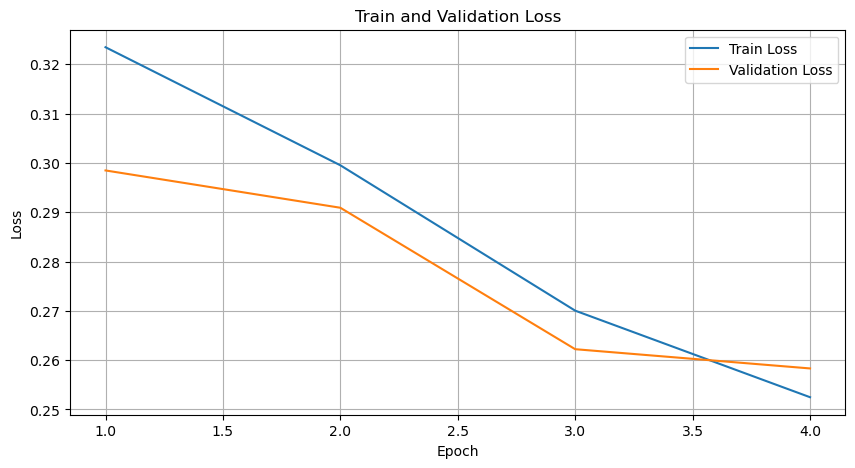

In [ ]:
plot_loss(train_losses, val_losses)

losses_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses
})
losses_df.to_csv('losses_unet.csv', index=False)

In [ ]:
def test_model_unet(model, test_loader, device, num_classes):
    
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Model prediction
            class_output, _ = model(images)
            preds = torch.sigmoid(class_output)

            predictions.append(preds.cpu())
            true_labels.append(labels.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  
    true_labels = torch.cat(true_labels, dim=0).numpy()  

    auc_scores = {}
    for i in range(num_classes):
        try:
            auc_val = roc_auc_score(true_labels[:, i], predictions[:, i])
            auc_scores[f'Class {i}'] = auc_val
        except ValueError:
            # Handle cases where all labels for a class are 0 or 1
            auc_scores[f'Class {i}'] = None

    return auc_scores

In [ ]:
auc_scores = test_model_unet(model, test_loader, device, num_classes)

with open('auc_scores_base.txt', 'w') as f:
    for class_name, auc in auc_scores.items():
        auc = round(auc, 3) if auc is not None else auc
        f.write(f"{class_name}: {auc if auc is not None else 'Undefined (all labels are 0 or 1)'}\n")
        print(f"{class_name}: {auc if auc is not None else 'Undefined (all labels are 0 or 1)'}")

Class 0: AUC = 0.8006819702523579
Class 1: AUC = 0.8029813716128098
Class 2: AUC = 0.8060314749922772
Class 3: AUC = 0.8802380538161747
Class 4: AUC = 0.7317382490982991
Class 5: AUC = 0.6631832666621467
Class 6: AUC = 0.714130125981622
Class 7: AUC = 0.7415506803241094
Class 8: AUC = 0.8528142588777471
Class 9: AUC = 0.8968232221180371
Class 10: AUC = 0.8305189694490411
Class 11: AUC = 0.7148114794182262
Class 12: AUC = 0.8509149845460282
Class 13: AUC = 0.888872277761898


In [ ]:
# ResNet Encoder (no decoder)

In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, num_classes=14, dropout_rate=0.3):
        super().__init__()
        base_model = models.resnet34(pretrained=True)
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4a

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))   # [B, 64, 112, 112]
        x2 = self.maxpool(x1)                     # [B, 64, 56, 56]
        x3 = self.layer1(x2)                      # [B, 64, 56, 56]
        x4 = self.layer2(x3)                      # [B, 128, 28, 28]
        x5 = self.layer3(x4)                      # [B, 256, 14, 14]
        x6 = self.layer4(x5)                      # [B, 512, 7, 7]

        gap_x6 = self.gap(x6).view(x6.size(0), -1) # [B, 512]
        gap_x6 = self.dropout(gap_x6)
        class_output = self.fc(gap_x6)             # [B, num_classes]

        return class_output

In [ ]:
def test_model_enc(model, test_loader, device, num_classes):

    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            class_output = model(images)
            preds = torch.sigmoid(class_output)

            predictions.append(preds.cpu())
            true_labels.append(labels.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  
    true_labels = torch.cat(true_labels, dim=0).numpy()  

    auc_scores = {}
    for i in range(num_classes):
        try:
            auc_val = roc_auc_score(true_labels[:, i], predictions[:, i])
            auc_scores[f'Class {i}'] = auc_val
        except ValueError:
            auc_scores[f'Class {i}'] = None

    return auc_scores

In [ ]:
def train_model_enc(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, pos_weight=None, best_model_path="model_enc.pth"):

    if pos_weight is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')  

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            images, labels = images.to(device), labels.to(device).float()

            class_output = model(images)
            loss = criterion(class_output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device).float()

                class_output = model(images)
                loss = criterion(class_output, labels)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "val_loss": val_loss,
            }, best_model_path)
            print(f"New best model saved at epoch {epoch+1} with Val Loss = {val_loss:.4f}")

    return train_losses, val_losses

In [ ]:
model = ResNetEncoder(num_classes=num_classes, dropout_rate=0.3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Users\JamesK\miniconda3\envs\cmu24\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\JamesK\miniconda3\envs\cmu24\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(model, input_size=(3, 224, 224))

In [ ]:
train_losses, val_losses = train_model_enc(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, pos_weight=pos_weight)

Epoch 1/4 - Validation: 100%|██████████| 235/235 [00:48<00:00,  4.88it/s]


Epoch 1: Train Loss = 0.2782, Val Loss = 0.2593
New best model saved at epoch 1 with Val Loss = 0.2593


Epoch 2/4 - Validation: 100%|██████████| 235/235 [00:47<00:00,  4.93it/s]


Epoch 2: Train Loss = 0.2543, Val Loss = 0.2549
New best model saved at epoch 2 with Val Loss = 0.2549


Epoch 3/4 - Validation: 100%|██████████| 235/235 [00:47<00:00,  4.95it/s]


Epoch 3: Train Loss = 0.2422, Val Loss = 0.2600


Epoch 4/4 - Validation: 100%|██████████| 235/235 [00:47<00:00,  4.97it/s]

Epoch 4: Train Loss = 0.2244, Val Loss = 0.2633


In [ ]:
auc_scores = test_model_enc(model, test_loader, device, num_classes)

with open('auc_scores_enc.txt', 'w') as f:
    for class_name, auc in auc_scores.items():
        auc = round(auc, 3) if auc is not None else auc
        f.write(f"{class_name}: {auc if auc is not None else 'Undefined (all labels are 0 or 1)'}\n")
        print(f"{class_name}: AUC = {auc if auc is not None else 'Undefined (all labels are 0 or 1)'}")

Class 0: AUC = 0.7975706262970075
Class 1: AUC = 0.7969959076605625
Class 2: AUC = 0.8016196127408524
Class 3: AUC = 0.8793532676121841
Class 4: AUC = 0.7411702697794728
Class 5: AUC = 0.6821209347526386
Class 6: AUC = 0.7172440744359493
Class 7: AUC = 0.7414899989807878
Class 8: AUC = 0.8465522283274944
Class 9: AUC = 0.8929939226002122
Class 10: AUC = 0.8490352000359414
Class 11: AUC = 0.710860651789696
Class 12: AUC = 0.8549025404226559
Class 13: AUC = 0.8872604885764253


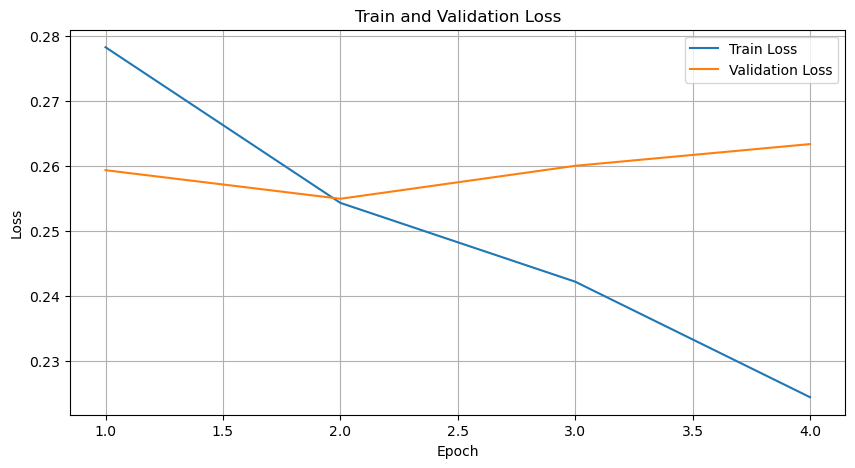

In [ ]:
plot_loss(train_losses, val_losses)

losses_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses
})
losses_df.to_csv('losses_unet.csv', index=False)